In [1]:
import os
import sys
#!{sys.executable} -m pip install statsmodels


import numpy as np
import pandas as pd
import sys; sys.path
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests as fdr
from matplotlib import colors

import warnings
warnings.filterwarnings('ignore')

In [2]:
results_dir   = 'results_directory_path'

ABCD_clin_labels = ['AnxDep', 'WithDep', 'Somatic', 'Social', 'Thought', 'Attention',
                    'RuleBreak', 'Aggresive', 'Internal', 'External', 'TotProb', 'Depress',
                    'AnxDiscord', 'SomaticPr', 'ADHD', 'Opposit', 'Conduct', 'Sluggish', 
                    'OCD', 'Stress']


#load in all of the prediction accuracy data for the true and the null models
rep = 100
n_beh = 20
corr_mm = np.zeros([n_beh,rep,n_beh])
corr_mf = np.zeros([n_beh,rep,n_beh])
corr_fm = np.zeros([n_beh,rep,n_beh])
corr_ff = np.zeros([n_beh,rep,n_beh])


null_rep = 1000
null_corr_mm = np.zeros([n_beh,null_rep,n_beh])
null_corr_mf = np.zeros([n_beh,null_rep,n_beh])
null_corr_fm = np.zeros([n_beh,null_rep,n_beh])
null_corr_ff = np.zeros([n_beh,null_rep,n_beh])

for i in range(len(ABCD_clin_labels)):
    
    corr_mm[i,:,:] = np.load(results_dir + '/fc_crossbehav_corr_mm_' + ABCD_clin_labels[i] + '.npy')
    corr_mf[i,:,:] = np.load(results_dir + '/fc_crossbehav_corr_mf_' + ABCD_clin_labels[i] + '.npy')
    corr_fm[i,:,:] = np.load(results_dir + '/fc_crossbehav_corr_fm_' + ABCD_clin_labels[i] + '.npy')
    corr_ff[i,:,:] = np.load(results_dir + '/fc_crossbehav_corr_ff_' + ABCD_clin_labels[i] + '.npy')
    
    null_corr_mm[i,:,:] = np.load(results_dir + '/fc_crossbehav_null_corr_mm_' + ABCD_clin_labels[i] + '.npy')
    null_corr_mf[i,:,:] = np.load(results_dir + '/fc_crossbehav_null_corr_mf_' + ABCD_clin_labels[i] + '.npy')
    null_corr_fm[i,:,:] = np.load(results_dir + '/fc_crossbehav_null_corr_fm_' + ABCD_clin_labels[i] + '.npy')
    null_corr_ff[i,:,:] = np.load(results_dir + '/fc_crossbehav_null_corr_ff_' + ABCD_clin_labels[i] + '.npy')



In [3]:
#compute average prediction accuracy
avg_corr_mm = np.mean(corr_mm, axis=1)
avg_corr_mf = np.mean(corr_mf, axis=1)
avg_corr_fm = np.mean(corr_fm, axis=1)
avg_corr_ff = np.mean(corr_ff, axis=1)

corr_m = np.hstack([avg_corr_mm, avg_corr_mf])
corr_f = np.hstack([avg_corr_fm, avg_corr_ff])

corr = np.vstack([corr_m, corr_f])

#np.savetxt((results_dir + '/summary_corr_corrected_5260.csv'), corr, delimiter=',')


In [4]:
#function to compare perforance between a model and its null 
def get_null_p(x,null):
    pval = 1-np.mean(x-null>=0)
    
    return pval

In [5]:
#compare true point estimate (mean) to entire null distribution
p_mm = np.zeros([n_beh,n_beh])
p_mf = np.zeros([n_beh,n_beh])
p_fm = np.zeros([n_beh,n_beh])
p_ff = np.zeros([n_beh,n_beh])


#get p vals for all models
for i in range(n_beh):
    for j in range(n_beh):
        p_mm[i,j] = get_null_p(np.mean(corr_mm[i,:,j]), null_corr_mm[i,:,j])
        p_mf[i,j] = get_null_p(np.mean(corr_mf[i,:,j]), null_corr_mf[i,:,j])
        p_fm[i,j] = get_null_p(np.mean(corr_fm[i,:,j]), null_corr_fm[i,:,j])
        p_ff[i,j] = get_null_p(np.mean(corr_ff[i,:,j]), null_corr_ff[i,:,j])
             
    
    #p_mm[i,:] = fdr(p_mm[i,:], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
    #p_mf[i,:] = fdr(p_mf[i,:], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
    #p_fm[i,:] = fdr(p_fm[i,:], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
    #p_ff[i,:] = fdr(p_ff[i,:], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
    

p_m = np.hstack([p_mm, p_mf])
p_f = np.hstack([p_fm, p_ff])

p = np.vstack([p_m, p_f])

#correct for multiple comparisons across all prediction accuracies
p_corr = fdr(p.ravel(), alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
p_corr = np.reshape(p_corr, (34, 34))


#np.sum(p_corr<(0.05))
#save accuracy data and corrected p values
np.savetxt((results_dir + '/summary_corr.csv'), corr, delimiter=',')
np.savetxt((results_dir + '/summary_p_corr.csv'), p_corr, delimiter=',')

161

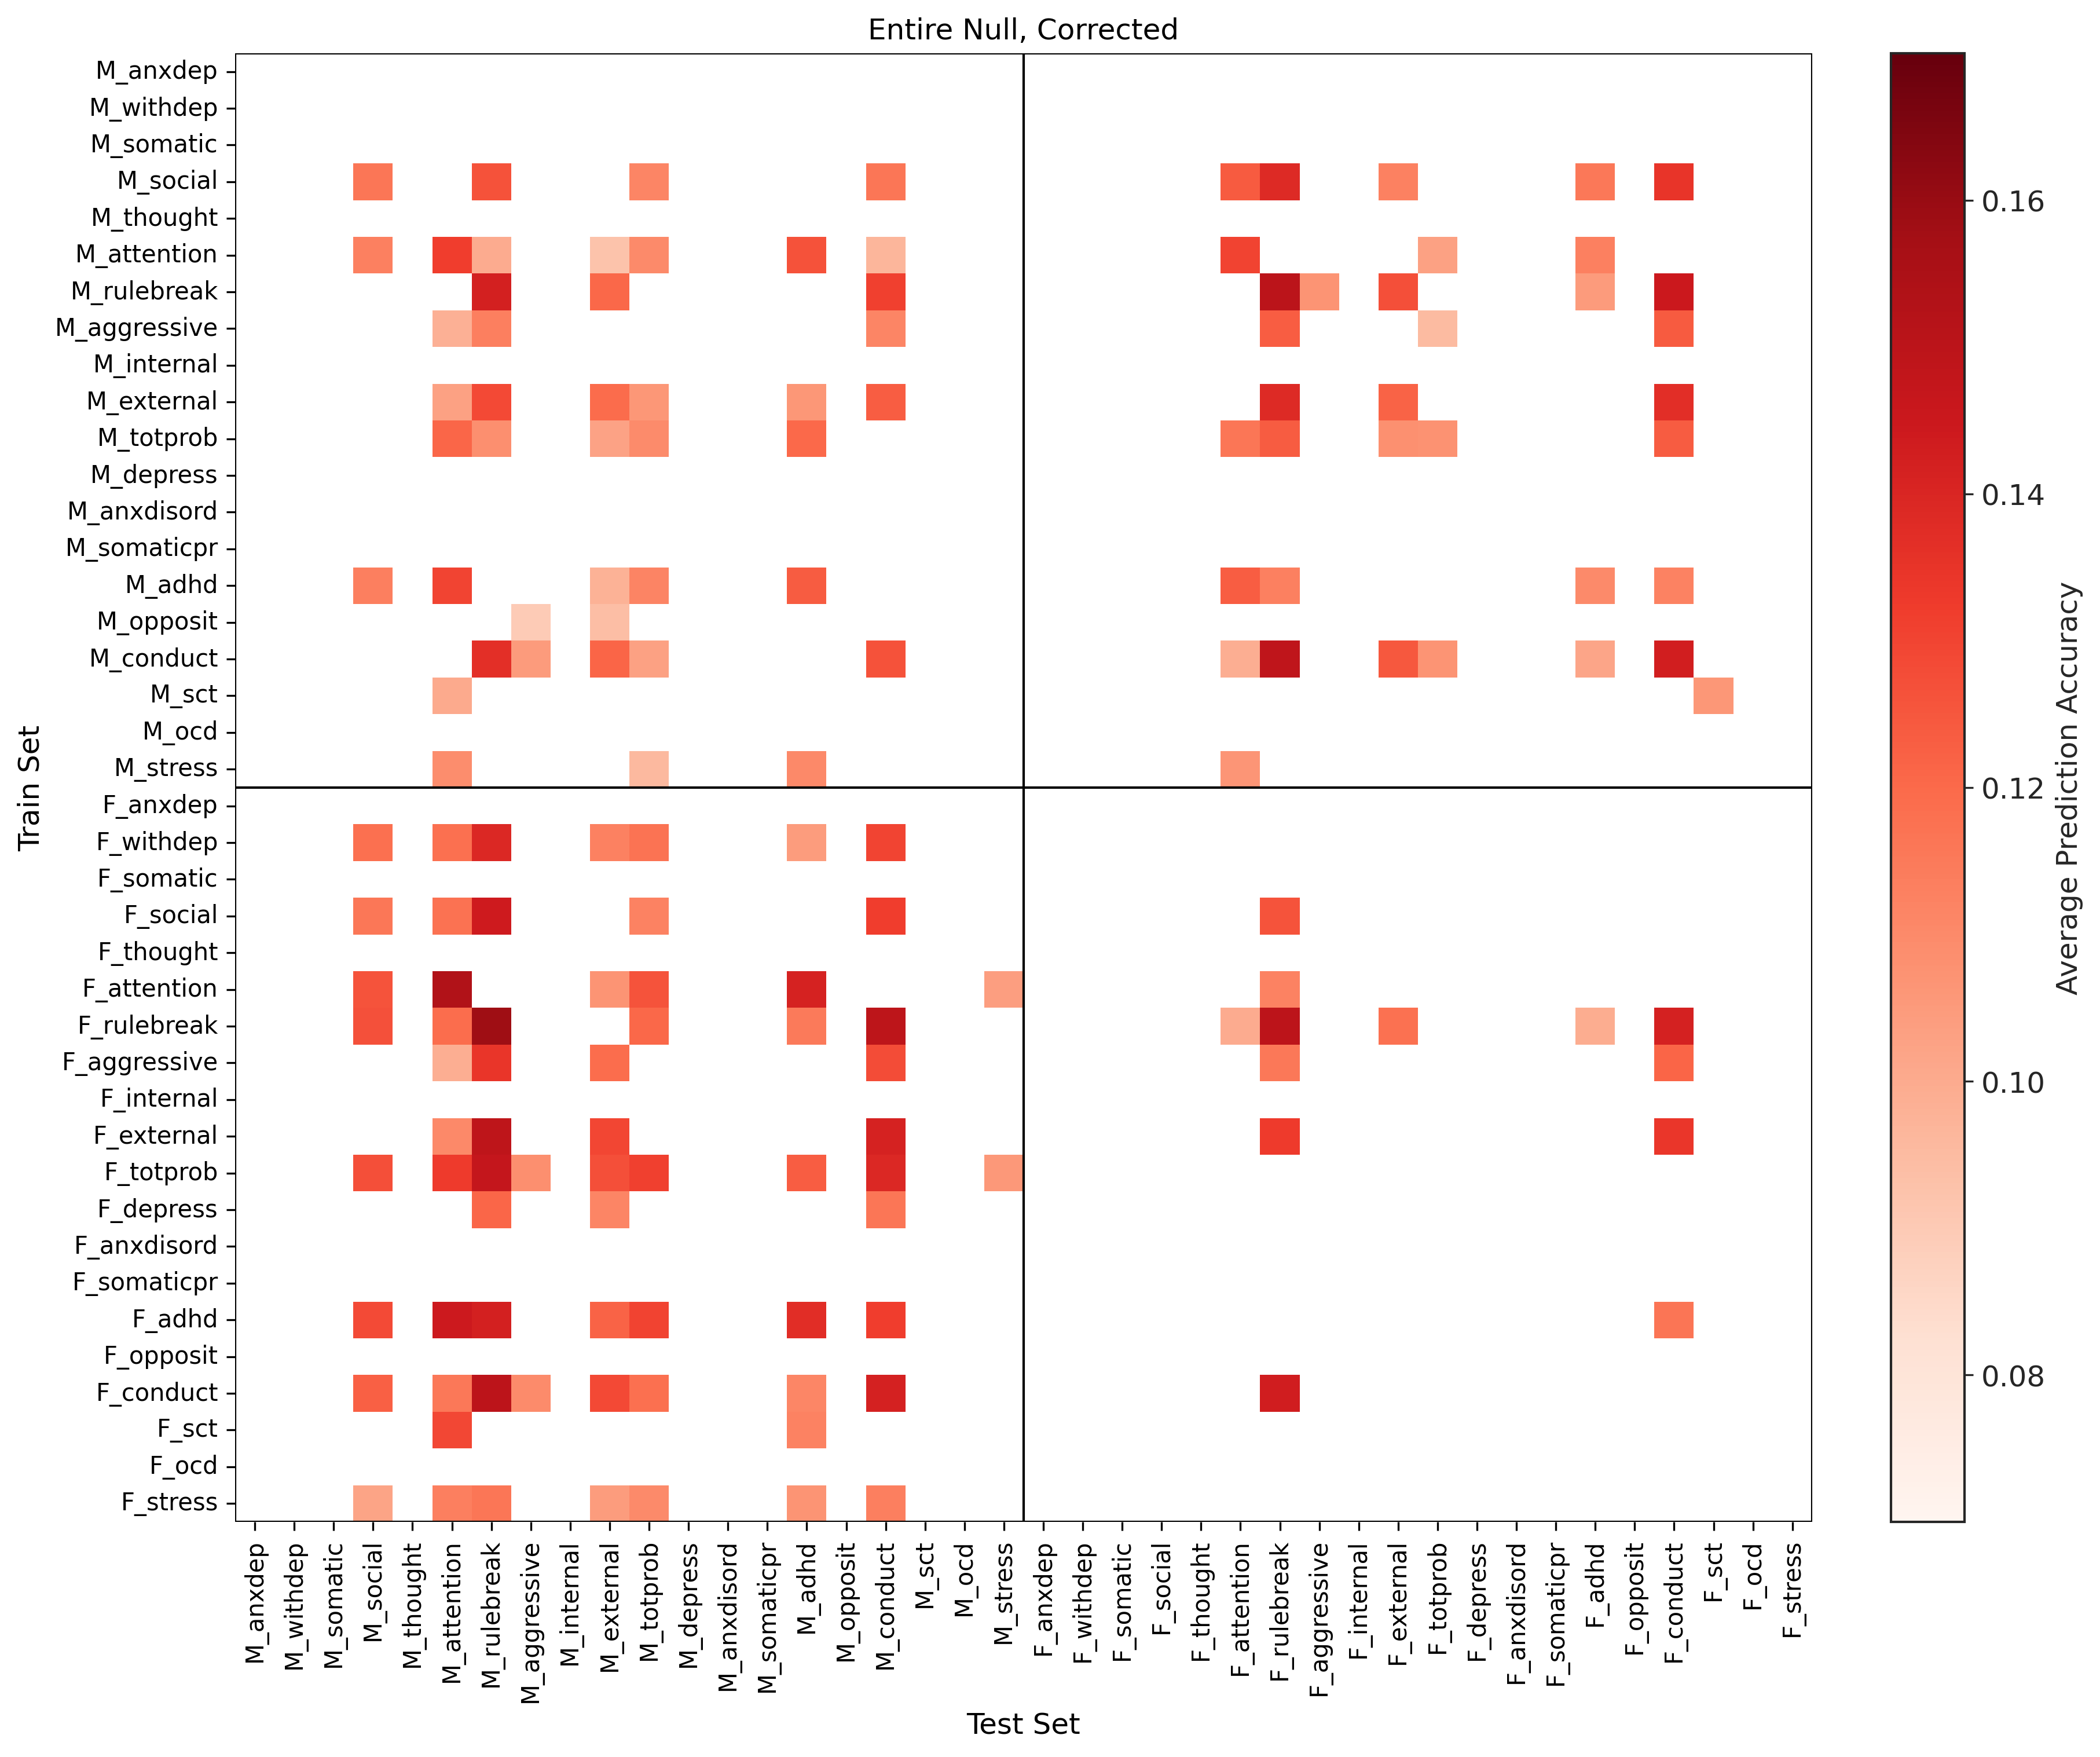

In [ ]:
#plot heatmaps that demonstrate mean prediction accuracy across all cognitive scores for different train/test sets
#also shows results for without (top row) and with (bottom row) ICV norm

labels = ['M_anxdep', 'M_withdep', 'M_somatic', 'M_social', 'M_thought', 'M_attention', 
          'M_rulebreak', 'M_aggressive', 'M_internal', 'M_external', 'M_totprob', 'M_depress',
          'M_anxdisord', 'M_somaticpr', 'M_adhd', 'M_opposit', 'M_conduct', 'M_sct',
          'M_ocd', 'M_stress', 'F_anxdep', 'F_withdep', 'F_somatic', 'F_social', 'F_thought', 'F_attention', 
          'F_rulebreak', 'F_aggressive', 'F_internal', 'F_external', 'F_totprob', 'F_depress',
          'F_anxdisord', 'F_somaticpr', 'F_adhd', 'F_opposit', 'F_conduct', 'F_sct',
          'F_ocd', 'F_stress']


vmin = -0.04
vmax = 0.20
cmap = 'Reds'
annot = False
dpi = 300
xticklabels = True
ticks = [-0.04, 0, 0.04, 0.08, 0.12, 0.16, 0.20]
cbar = True
tight = True
cbar_kws = {"orientation": "vertical", "ticks": ticks}



#divnorm=colors.TwoSlopeNorm(vmin=0.05, vcenter=0.10, vmax=0.13)

num_comp = 40*40
mask = p<(0.05/num_comp)
mask = np.double(mask)

data = corr

#data[data==0] = np.nan

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[12, 10], dpi=dpi, constrained_layout=tight)
sns.set_style(style="white")

ax = sns.heatmap(data,  cbar=cbar, cmap=cmap, xticklabels=labels, annot=annot, yticklabels=labels, 
                vmin=vmin, vmax=vmax)

fontsize=12

ax.set_title('Entire Null, Corrected', fontsize=fontsize)
ax.set_ylabel('Train Set', fontsize=fontsize)
ax.set_xlabel('Test Set', fontsize=fontsize)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=fontsize, which='major')
cbar.set_label("Average Prediction Accuracy",fontsize=fontsize)
cbar.outline.set_linewidth(1)



lw = 1
color = 'k'


ax.axhline(0,  linewidth=lw, color=color, dashes=(1, 0))
ax.axvline(0,  linewidth=lw, color=color, dashes=(1, 0))
ax.axhline(20,  linewidth=lw, color=color, dashes=(1, 0))
ax.axvline(20,  linewidth=lw, color=color, dashes=(1, 0))
ax.axhline(40,  linewidth=lw, color=color, dashes=(1, 0))
ax.axvline(40,  linewidth=lw, color=color, dashes=(1, 0))


#plt.savefig((results_dir + '/entirenull_corrected.png'), dpi=900, bbox_inches="tight") 


In [ ]:
np.min(corr)